# 2 Gradient decent methods


We re-use the quadratic function from last exercise $f: \mathcal{R}^2 \rightarrow \mathcal{R}$ defined as 

$$
f(\mathbf{x}) = (\mathbf{x} - \tilde{\mathbf{x}}) \cdot \mathbf{Q} \cdot (\mathbf{x} - \tilde{\mathbf{x}})
$$
with 
$$
\mathbf{Q} = 
\begin{pmatrix}
    2 & 1 \\
    1 & 1 
\end{pmatrix} 
\quad 
\text{and}
\quad
\tilde{\mathbf{x}} = 
\begin{pmatrix}
    -1\\
    1 
\end{pmatrix}
$$
to test the implemented gradient decent methods. The optimum of this function is $\mathbf{x}^*=\tilde{\mathbf{x}}$.

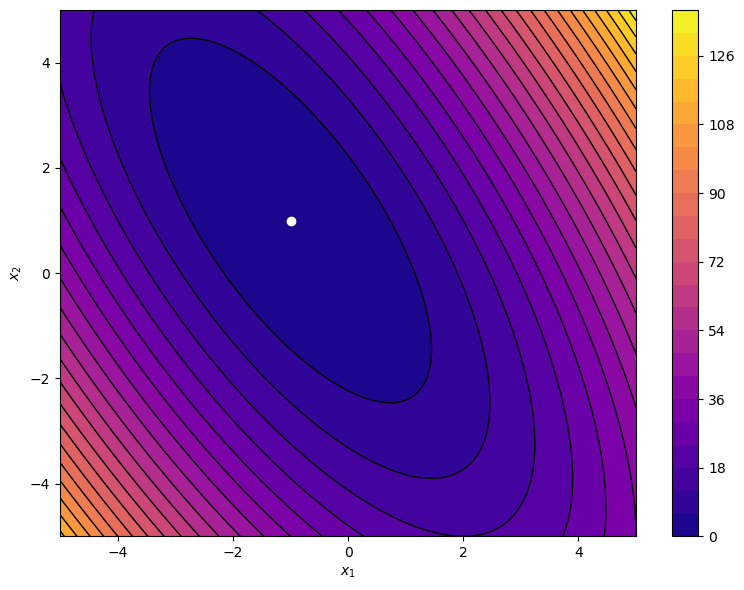

In [168]:
import numpy as np
import torch
from utils import plot_contours

# Define domain
x0 = torch.linspace(-5, 5, steps=100)
x1 = torch.linspace(-5, 5, steps=100)
x = torch.stack(torch.meshgrid(x0, x1, indexing="xy"), dim=2)

# Define constants
xt = torch.tensor([-1.0, 1.0])
Q = torch.tensor([[2.0, 1.0], [1, 1.0]])


# Define function
def f(x):
    dx = x - xt
    return torch.einsum("...i,ij,...j", dx, Q, dx)


# Plot function as contour lines
plot_contours(x[:, :, 0], x[:, :, 1], f(x), opti=[-1, 1])


## Task 1 - Simple steepest decent

We have a predfined function named `simple_decent(x_init, func, eta=0.1, maxiter=100)` that takes an intial point $\mathbf{x}_0 \in \mathcal{R}^d$ named `x_init`, a function `func`, a step size `eta`, and an iteration limit `max_iter`. 

Implement a simple steepest gradient decent in that function. The function should return a list of all steps $\mathbf{x}_k \in \mathcal{R}^d$ taken during the optimization, i.e. `[[x1_0, x2_0, ..., xd_0], [x1_1, x2_1, ..., xd_1], ...]`

In [169]:
def simple_decent(x_init, func, eta=0.1, max_iter=100):
    x = x_init.clone().requires_grad_()

    points = []
    for _ in range(max_iter):
        # Save intermediate results
        points.append([xi.item() for xi in x])
        # Compute gradient
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        # Make a step
        x.data -= eta * grad

    return points


Test the function with the following code for 
$$
    \mathbf{x}_0 = 
\begin{pmatrix}
    4\\
    -1 
\end{pmatrix}
$$
and play around with the optional parameters. 

Final values are x_1=-0.999, x_2=0.999


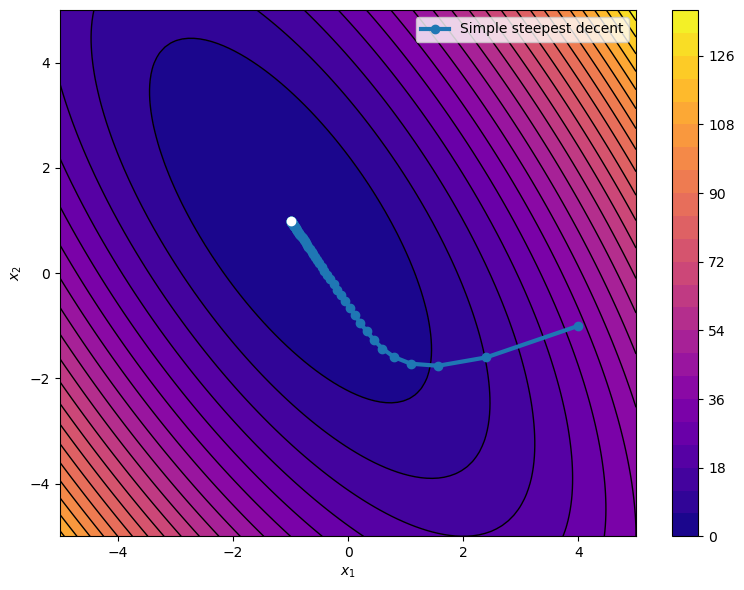

In [170]:
x_init = torch.tensor([4.0, -1.0])
path = simple_decent(x_init, f)
plot_contours(
    x[:, :, 0],
    x[:, :, 1],
    f(x),
    opti=[-1, 1],
    paths={"Simple steepest decent": path},
)
print(f"Final values are x_1={path[-1][0]:.3f}, x_2={path[-1][1]:.3f}")


## Task 2 - Steepest decent method with incomplete line search

We have a predfined function named `incomplete_line_search(x_init, func, eta_0=5.0, c=0.5, rho=0.8, maxiter=10)` that takes an intial point $\mathbf{x}_0 \in \mathcal{R}^d$ named `x_init`, a function `func`, an initial step size `eta_0`, a Armijo constant `c`, a backtracking reduction factor `rho` and an iteration limit `max_iter`.

Implement a steepest gradient decent with incompleted line search using the backtracking algorithm in that function. The function should return a list of all steps $\mathbf{x}_k \in \mathcal{R}^d$ taken during the optimization, i.e. `[[x1_0, x2_0, ..., xd_0], [x1_1, x2_1, ..., xd_1], ...]`

In [171]:
def incomplete_line_search(x_init, func, eta_0=5.0, c=0.5, rho=0.8, max_iter=10):
    x = x_init.clone().requires_grad_()

    points = []
    for _ in range(max_iter):
        # Save intermediate results
        points.append([xi.item() for xi in x])
        # Compute direction
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        grad_norm = grad.norm()
        p = -grad / grad_norm
        # Backtracking algorithm for incomplete line search
        eta = eta_0
        while func(x + eta * p) > func(x) + c * eta * torch.dot(grad, p):
            eta *= rho
        # Make a step
        x.data += eta * p

    return points


Test the function with the following code for 
$$
    \mathbf{x}_0 = 
\begin{pmatrix}
    4\\
    -1 
\end{pmatrix}
$$
and play around with the optional arguments.

Final values are x_1=-0.985, x_2=0.970


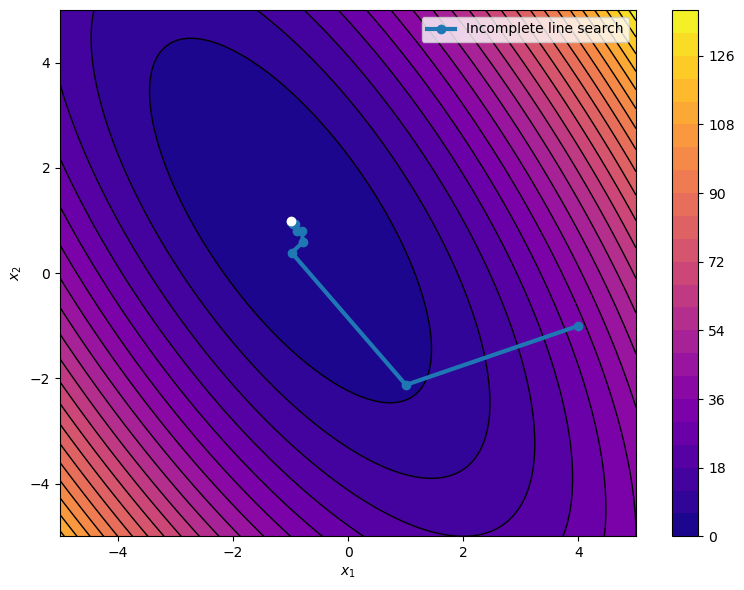

In [172]:
x_init = torch.tensor([4.0, -1.0])
path = incomplete_line_search(x_init, f)
plot_contours(x[:, :, 0], x[:, :, 1], f(x), opti=[-1, 1], paths={"Incomplete line search": path})
print(f"Final values are x_1={path[-1][0]:.3f}, x_2={path[-1][1]:.3f}")


## Task 3 - Steepest decent method with complete line search

We have a predfined function named `complete_line_search(x_init, func, maxiter=10)` that takes an intial point $\mathbf{x}_0 \in \mathcal{R}^d$ named `x_init`, a function `func`, and an iteration limit `max_iter`.

Implement a steepest gradient decent with completed line search re-using the previous `incomplete_line_search` to solve the subproblem of finding the optimal step size $\eta^*_k$. The function should return a list of all steps $\mathbf{x}_k \in \mathcal{R}^d$ taken during the optimization, i.e. `[[x1_0, x2_0, ..., xd_0], [x1_1, x2_1, ..., xd_1], ...]`

In [173]:
def complete_line_search(x_init, func, max_iter=10):
    x = x_init.clone().requires_grad_()

    points = []
    for _ in range(max_iter):
        # Save intermediate results
        points.append([xi.item() for xi in x])
        # Compute direction
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        grad_norm = grad.norm()
        p = -grad / grad_norm
        # Solve subproblem with incomplete line search
        eta_0 = torch.tensor([1.0])
        etas = incomplete_line_search(eta_0, lambda eta: func(x + eta * p))
        # Make a step
        x.data += etas[-1][0] * p

    return points


Test the function with the following code for 
$$
    \mathbf{x}_0 = 
\begin{pmatrix}
    4\\
    -1 
\end{pmatrix}
$$
and discuss why an incomplete line search is usually choosen over a complete line search.

Final values are x_1=-0.999, x_2=0.998


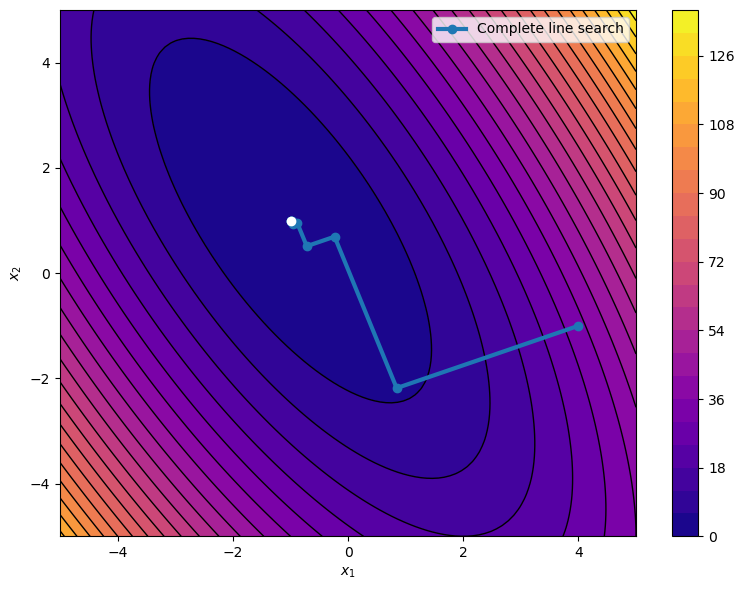

In [174]:
x_init = torch.tensor([4.0, -1.0])
path = complete_line_search(x_init, f)
plot_contours(x[:, :, 0], x[:, :, 1], f(x),opti=[-1, 1], paths={"Complete line search": path})
print(f"Final values are x_1={path[-1][0]:.3f}, x_2={path[-1][1]:.3f}")


## Task 4 - Conjugated gradients
We have a predfined function named `cg(x_init, func, maxiter=5)` that takes an intial point $\mathbf{x}_0 \in \mathcal{R}^d$ named `x_init`, a function `func`, and an iteration limit `max_iter`.

Implement the conjugated gradients method in that function re-using the previous `incomplete_line_search` to solve the subproblem of finding the optimal step size $\eta^*_k$. The function should return a list of all steps $\mathbf{x}_k \in \mathcal{R}^d$ taken during the optimization, i.e. `[[x1_0, x2_0, ..., xd_0], [x1_1, x2_1, ..., xd_1], ...]`

In [175]:
def cg(x_init, func, max_iter=5):
    x = x_init.clone().requires_grad_()

    points = []
    for i in range(max_iter):
        points.append([xi.item() for xi in x])
        # Compute gradient
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        # Compute conjugated direction
        if i > 0:
            beta = torch.dot(grad, grad) / torch.dot(grad_old, grad_old)
            p = -grad + beta * p_old
        else:
            p = -grad
        # Solve subproblem with incomplete line search
        eta_0 = torch.tensor([1.0])
        etas = incomplete_line_search(eta_0, lambda eta: func(x + eta * p))
        # Make a step
        x.data += etas[-1][0] * p
        # Store gradients
        grad_old = grad
        p_old = p

    return points


Test the function with the following code for 
$$
    \mathbf{x}_0 = 
\begin{pmatrix}
    4\\
    -1 
\end{pmatrix}
$$
and discuss its benefits and drawbacks.

Final values are x_1=-1.000, x_2=1.000


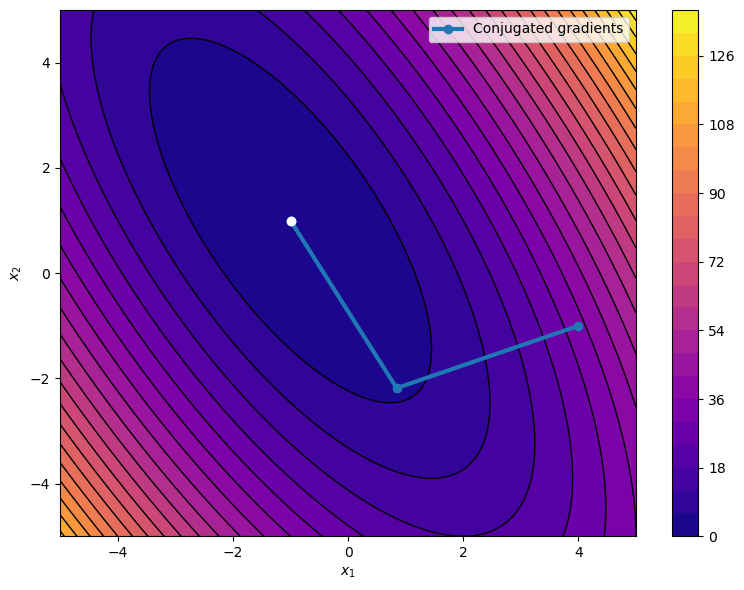

In [176]:
x_init = torch.tensor([4.0, -1.0])
path = cg(x_init, f)
plot_contours(x[:, :, 0], x[:, :, 1], f(x),opti=[-1, 1], paths={"Conjugated gradients": path})
print(f"Final values are x_1={path[-1][0]:.3f}, x_2={path[-1][1]:.3f}")


## Task 5 - BFGS 
We have a predfined function named `bfgs(x_init, func, maxiter=5)` that takes an intial point $\mathbf{x}_0 \in \mathcal{R}^d$ named `x_init`, a function `func`, and an iteration limit `max_iter`.

Implement the BFGS method in that function re-using the previous `incomplete_line_search` to solve the subproblem of finding the optimal step size $\eta^*_k$. The function should return a list of all steps $\mathbf{x}_k \in \mathcal{R}^d$ taken during the optimization, i.e. `[[x1_0, x2_0, ..., xd_0], [x1_1, x2_1, ..., xd_1], ...]`

In [177]:
def bfgs(x_init, func, max_iter=5):
    x = x_init.clone().requires_grad_()

    points = []
    d = x.size(dim=0)
    I = torch.eye(d)
    H_i = I.clone()
    for _ in range(max_iter):
        points.append([xi.item() for xi in x])
        # Compute gradient
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        # Compute search direction
        p = -H_i @ grad
        # Solve subproblem with incomplete line search decent
        eta_0 = torch.tensor([1.0])
        etas = incomplete_line_search(eta_0, lambda eta: func(x + eta * p))
        # Make a step
        x.data += etas[-1][0] * p
        # Difference of gradients
        y = torch.autograd.grad(func(x).sum(), x)[0] - grad
        py = torch.inner(p, y)
        H_i = (I - torch.outer(p, y) / py) @ H_i @ (
            I - torch.outer(y, p) / py
        ) + torch.outer(p, p) / py

    return points


Test the function with the following code for 
$$
    \mathbf{x}_0 = 
\begin{pmatrix}
    4\\
    -1 
\end{pmatrix}
$$
and discuss its benefits and drawbacks.

Final values are x_1=nan, x_2=nan


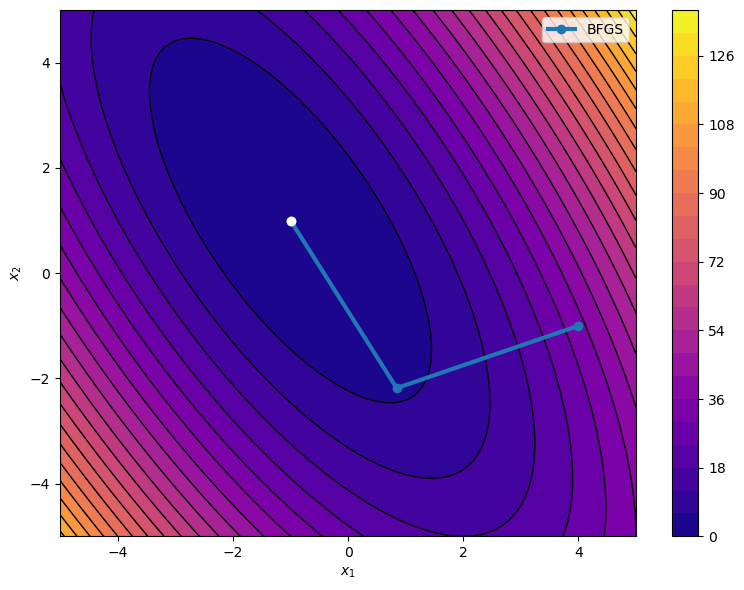

In [178]:
x_init = torch.tensor([4.0, -1.0])
path = bfgs(x_init, f)
plot_contours(x[:, :, 0], x[:, :, 1], f(x),opti=[-1, 1], paths={"BFGS": path},)
print(f"Final values are x_1={path[-1][0]:.3f}, x_2={path[-1][1]:.3f}")


## Task 6 - Comparison
The following code plots all optimization paths on the given quadratic problem. 

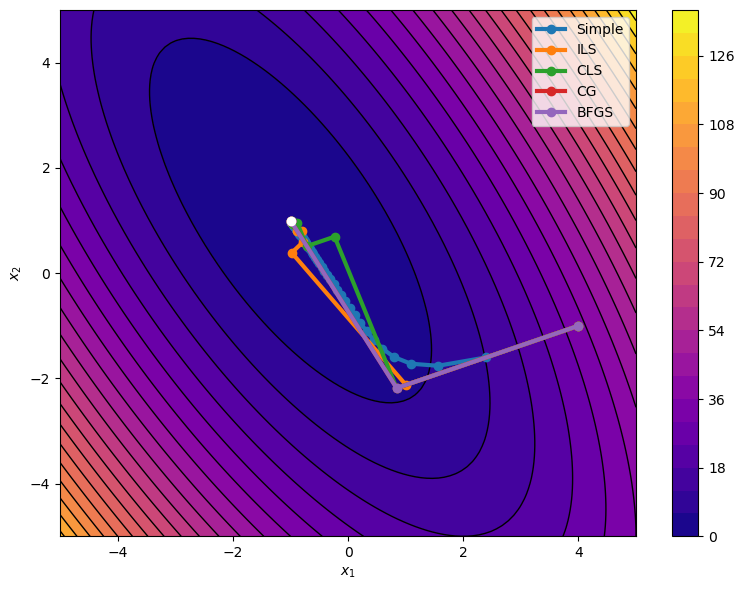

In [179]:
x_init = torch.tensor([4.0, -1.0])
path_simple = simple_decent(x_init, f)
path_ils = incomplete_line_search(x_init, f)
path_cls = complete_line_search(x_init, f)
path_cg = cg(x_init, f)
path_bfgs = bfgs(x_init, f)
plot_contours(
    x[:, :, 0],
    x[:, :, 1],
    f(x),
    opti=[-1, 1],
    paths={
        "Simple": path_simple,
        "ILS": path_ils,
        "CLS": path_cls,
        "CG": path_cg,
        "BFGS": path_bfgs,
    },
)


The quadratic problem is a rather easy optimization problem. Compare the algorithms for some hard optimization test functions (`himmelblau_function` and `rosenbrock_function`) and different start points.

Results:
Simple: x_1=3.000, x_2=2.000
ILS: x_1=3.000, x_2=2.000
CLS: x_1=3.000, x_2=2.000
CG: x_1=3.148, x_2=2.809
BFGS: x_1=2.878, x_2=2.220


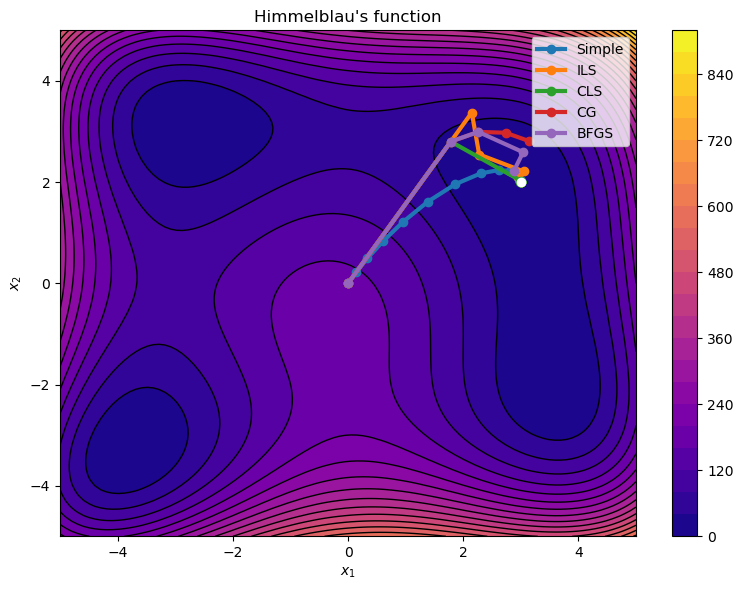

In [180]:
def himmelblau_function(x):
    return (x[...,0]**2 + x[...,1] - 11) ** 2 + (x[...,0] + x[...,1]**2 - 7) ** 2

x_init = torch.tensor([0.0, 0.0])
path_simple = simple_decent(x_init, himmelblau_function, eta=0.01)
path_ils = incomplete_line_search(x_init, himmelblau_function)
path_cls = complete_line_search(x_init, himmelblau_function)
path_cg = cg(x_init, himmelblau_function)
path_bfgs = bfgs(x_init, himmelblau_function)
plot_contours(
    x[:, :, 0],
    x[:, :, 1],
    himmelblau_function(x),
    title="Himmelblau's function",
    opti=[3, 2],
    paths={
        "Simple": path_simple,
        "ILS": path_ils,
        "CLS": path_cls,
        "CG": path_cg,
        "BFGS": path_bfgs,
    },
)
print("Results:")
print(f"Simple: x_1={path_simple[-1][0]:.3f}, x_2={path_simple[-1][1]:.3f}")
print(f"ILS: x_1={path_ils[-1][0]:.3f}, x_2={path_ils[-1][1]:.3f}")
print(f"CLS: x_1={path_cls[-1][0]:.3f}, x_2={path_cls[-1][1]:.3f}")
print(f"CG: x_1={path_cg[-1][0]:.3f}, x_2={path_cg[-1][1]:.3f}")
print(f"BFGS: x_1={path_bfgs[-1][0]:.3f}, x_2={path_bfgs[-1][1]:.3f}")

Results:
Simple: x_1=0.994, x_2=0.989
ILS: x_1=1.000, x_2=1.000
CLS: x_1=3.000, x_2=2.000
BFGS: x_1=nan, x_2=nan


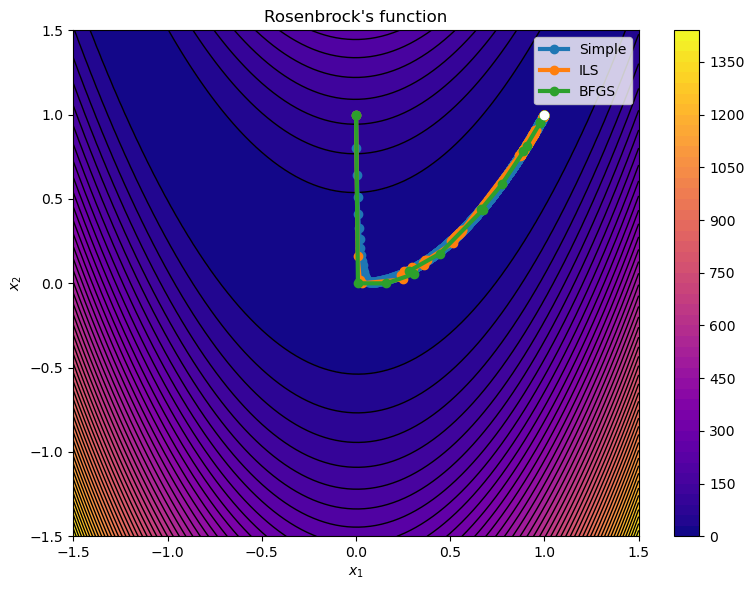

In [185]:
# Define domain
x0 = torch.linspace(-1.5, 1.5, steps=100)
x1 = torch.linspace(-1.5, 1.5, steps=100)
x = torch.stack(torch.meshgrid(x0, x1, indexing="xy"), dim=2)

def rosenbrock_function(x):
    return 100 * (x[...,1] - x[...,0]**2) ** 2 + (1 - x[...,0]) ** 2

x_init = torch.tensor([0., 1.])
path_simple = simple_decent(x_init, rosenbrock_function, eta=0.001, max_iter=10000)
path_ils = incomplete_line_search(x_init, rosenbrock_function, max_iter=500)
path_bfgs = bfgs(x_init, rosenbrock_function, max_iter=20)
plot_contours(
    x[:, :, 0],
    x[:, :, 1],
    rosenbrock_function(x),
    title="Rosenbrock's function",
    opti=[1, 1],
    levels=50,
    paths={
        "Simple": path_simple,
        "ILS": path_ils,
        "BFGS": path_bfgs,
    },
)
print("Results:")
print(f"Simple: x_1={path_simple[-1][0]:.3f}, x_2={path_simple[-1][1]:.3f}")
print(f"ILS: x_1={path_ils[-1][0]:.3f}, x_2={path_ils[-1][1]:.3f}")
print(f"CLS: x_1={path_cls[-1][0]:.3f}, x_2={path_cls[-1][1]:.3f}")
print(f"BFGS: x_1={path_bfgs[-1][0]:.3f}, x_2={path_bfgs[-1][1]:.3f}")